# 1. Set up

In [1]:
source('setup.R')

df <- readRDS('nsclc_egfr_pm25_09022015.rds') 

In [2]:
# subset data
SUBSET_CONDITION <- list(
    Predicted_Pop = 'EUR',
    SMOKE3 = NA
)

for (var in names(SUBSET_CONDITION)) {
    val <- SUBSET_CONDITION[[var]]
    if (!is.na(val)) {
        df <- df %>% filter(.data[[var]] == val)
        cat('after filtering', var, ':', nrow(df), '\n')
    }
}

after filtering Predicted_Pop : 2312 


In [3]:
OUTCOME <- "EGFR"

COVAR_BASELINE <- c(
    "AGE", "GENDER_NM", "PANEL_VERSION", "STAGE", "YEAR_TEST", "SMOKE3", 
    "PC1", "PC2", "PC3", "PC4", "PC5", "LUAD"
)

COVAR_TMB <- "MUTATIONAL_BURDEN"
COVAR_SES <- c("avg_pct_poverty", "avg_med_income", "avg_pct_low_edu")

VAR_COMP <- c( "br", "ca", "cu", "ec", "fe", "k", "nh4", 
              "ni", "no3", "oc", "pb", "si", "so4", "v", "z")

# 2 Run susie

## 2.1 functions

In [4]:
remove.covariate.effects <- function(X, Z, y) {
    # Include the intercept term
    if (any(Z[, 1] != 1)) Z <- cbind(1, Z)
    A <- crossprod(Z)
    SZy <- as.vector(solve(A, c(y %*% Z)))
    SZX <- as.matrix(solve(A, t(Z) %*% X))
    y <- y - c(Z %*% SZy)
    X <- X - Z %*% SZX
    return(list(X = X, y = y, SZy = SZy, SZX = SZX))
}

## 2.2 prepare covariates matrix Z

In [5]:
# select variables
COVAR_LIST <- c(COVAR_BASELINE, COVAR_TMB, COVAR_SES)

if (!is.na(SUBSET_CONDITION$SMOKE3)){
    COVAR_LIST <- setdiff(COVAR_LIST, "SMOKE3")
}
COVAR_LIST
Z_df <- df %>% select(all_of(COVAR_LIST))

# Identify categorical/binary variables
is_categorical <- function(x) is.factor(x) || is.character(x) || is.logical(x)
categorical_vars <- names(Z_df)[sapply(Z_df, is_categorical)]
categorical_vars

# convert categorical variables into dummy variables
Z_df <- Z_df %>%
    mutate(across(all_of(categorical_vars), as.factor))
Z <- model.matrix(~ ., data = Z_df)
Z <- as.matrix(Z)

[1] "AGE"               "GENDER_NM"         "PANEL_VERSION"    
 [4] "STAGE"             "YEAR_TEST"         "SMOKE3"           
 [7] "PC1"               "PC2"               "PC3"              
[10] "PC4"               "PC5"               "LUAD"             
[13] "MUTATIONAL_BURDEN" "avg_pct_poverty"   "avg_med_income"   
[16] "avg_pct_low_edu"

[1] "GENDER_NM"     "PANEL_VERSION" "STAGE"         "SMOKE3"       
[5] "LUAD"

## 2.3 prepare X

In [6]:
X <- df %>% select(all_of(VAR_COMP)) %>% 
    mutate(across(all_of(VAR_COMP), scale)) %>% as.matrix()


## 2.4 prepare Y

In [7]:
y <- df %>% pull(OUTCOME)

## 2.4 run susie

In [8]:
# remove covariate effect 
library(susieR)
out <- remove.covariate.effects(X, Z, y)
# fit susie 
fitted <- susie(out$X, out$y, L = 2)
# get pip
pip_values <- susie_get_pip(fitted)
names(pip_values) <- VAR_COMP
round(rev(sort(pip_values)),2)

oc   br  no3  nh4   ca    v  so4   fe   cu   ni   ec   si   pb    k    z 
0.54 0.12 0.09 0.06 0.04 0.04 0.03 0.02 0.02 0.01 0.01 0.01 0.00 0.00 0.00

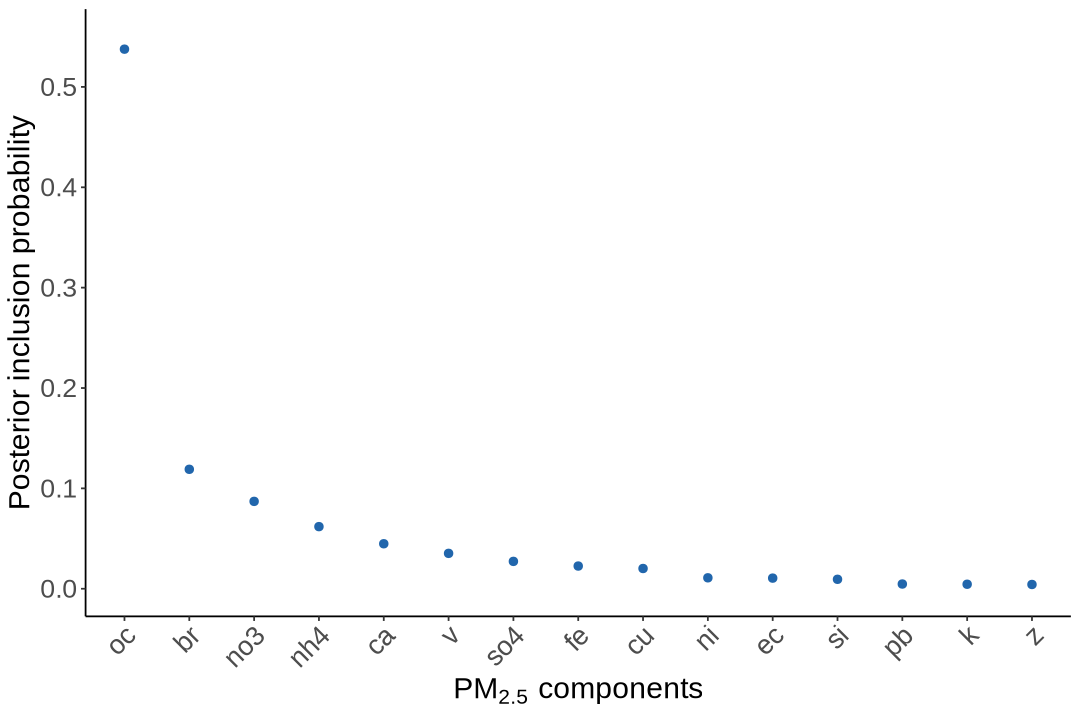

In [9]:
plot_df <- data.frame(param = VAR_COMP, pip = pip_values) %>%
    arrange(desc(pip_values)) %>% 
    mutate(param = factor(param, levels = param))

set_fig_size(6, 9)
p2 <- ggplot(plot_df, aes(x = param, y = pip)) +
    geom_point(size = 2, color = '#2166AC') + 
    labs(x = expression(PM[2.5] ~ "components"), y = "Posterior inclusion probability") +
    my_theme() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    scale_y_continuous(
        limits = c(0, 0.55),
        breaks = seq(0, 0.5, 0.1)
    )
p2

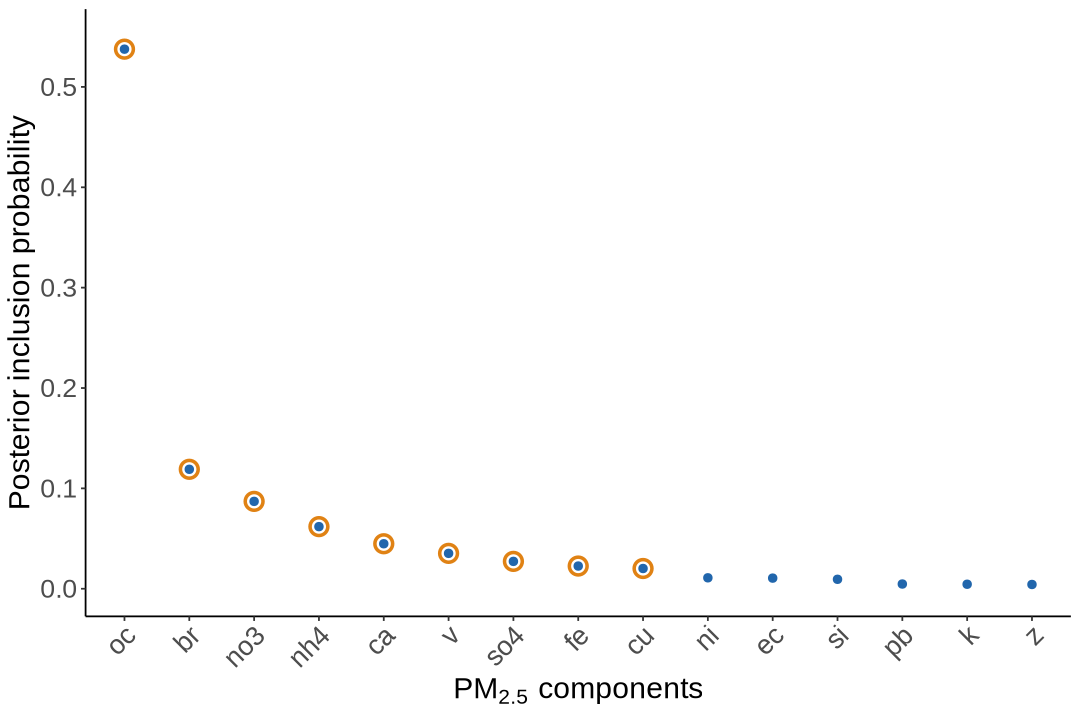

In [10]:
# Extract credible set variables
cs_vars <- VAR_COMP[susie_get_cs(fitted)$cs$L1]

# Plot
p2 <- ggplot(plot_df, aes(x = param, y = pip)) +
    geom_point(size = 2, color = '#2166AC') + 
    # highlight credible set variables
    geom_point(
        data = subset(plot_df, param %in% cs_vars),
        aes(x = param, y = pip),
        size = 4, shape = 21, stroke = 1.5, color = "#E08214", fill = NA
    ) +
    labs(x = expression(PM[2.5] ~ "components"), y = "Posterior inclusion probability") +
    my_theme() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    scale_y_continuous(
        limits = c(0, 0.55),
        breaks = seq(0, 0.5, 0.1)
    )

p2

# 3 Get marginal association

In [11]:
# normalize parameters
scaled_df <- df %>%
    mutate(across(all_of(VAR_COMP), scale))

In [12]:
# get all association statistics
f <- paste0('EGFR ~ {var} + ', paste0(COVAR_LIST, collapse = ' + '))
cat(f)
rls_list <- list()
system.time(
for (var in VAR_COMP){
    model <- glm(as.formula(glue(f)), data = scaled_df, family = binomial())
    rls_list[[var]] <- summary_result(model, var)
})

EGFR ~ {var} + AGE + GENDER_NM + PANEL_VERSION + STAGE + YEAR_TEST + SMOKE3 + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD + MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu

   user  system elapsed 
 45.999   0.394  21.764 

In [13]:
# munge 
rls_df <- bind_rows(rls_list) %>%
    arrange(pval) %>%
    mutate(param = factor(param, levels = levels(plot_df$param)), qval = p.adjust(pval, method = 'BH')) %>%
    mutate(significant = case_when(
        pval < 0.05 / length(VAR_COMP) ~ "***",  # Assign "**" for highly significant p-values
        qval < 0.05 ~ "**",
        pval < 0.05 ~ "*",                  # Assign "*" for significant p-values
        TRUE ~ ""                           # Assign "" for non-significant p-values
    ))


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


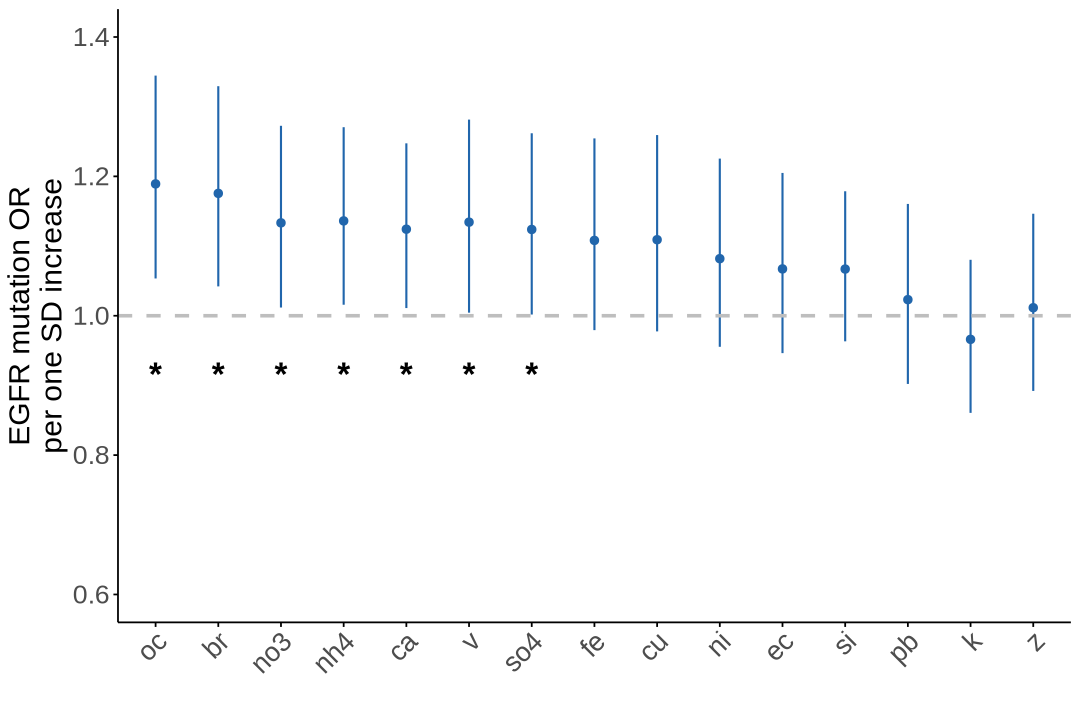

In [14]:
set_fig_size(6, 9)

p1 <- ggplot(rls_df, aes(x = param, y = OR)) + 
    geom_point(color = '#2166AC', size = 2) + 
    geom_errorbar(aes(ymin = OR_CI_lower, ymax = OR_CI_upper), color = '#2166AC', width = 0, size = 0.6) +
    scale_y_log10() + 
    theme_minimal() + 
     geom_hline(yintercept=1, linetype="dashed", color = "grey", size = 1) +
    labs(y = "EGFR mutation OR\nper one SD increase", x = "PM2.5 mass and components") + 
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1), 
        legend.position = "none"
    ) + 
    my_theme() +
    geom_text(
        aes(label = significant, y = 0.9), 
        position = position_dodge(width = 0.1), 
        vjust = 0, color = "black", 
        fontface = 'bold', size = 7
    ) + xlab('') +scale_y_continuous(limit = c(0.6,1.4), breaks = seq(0.6,1.8, 0.2))
p1

# 4 plot correlation matrix

corrplot 0.95 loaded



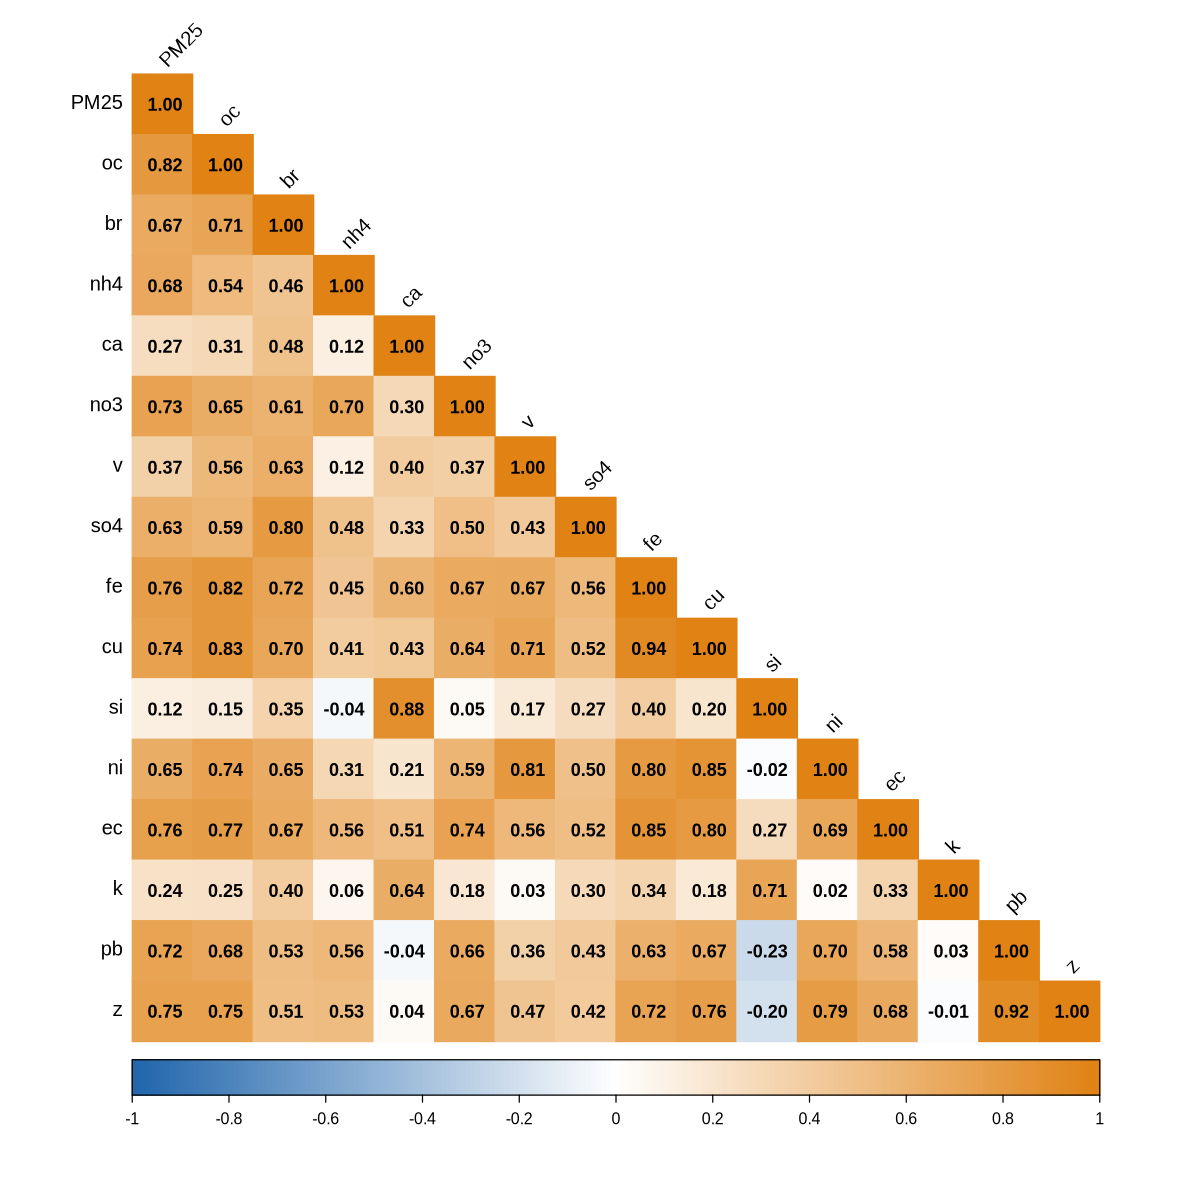

In [15]:
set_fig_size(10, 10)

comp_order <- rownames(rls_df)
comp_order <- c('PM25', comp_order[comp_order!='PM25'])
cor_matrix <- df %>%
    select(comp_order) %>%  # avoid duplicate
    cor(use = "pairwise.complete.obs")

library(corrplot)
corrplot(cor_matrix,
         method = "color",
         col = colorRampPalette(c("#2166AC", "white", "#E08214"))(200),  # blue–gray–orange
         type = "lower",
         order = "original",
         tl.col = "black",
         tl.srt = 45,
         addCoef.col = "black",
         tl.cex = 1,
         number.cex = 0.9)

# 5 combine plots


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




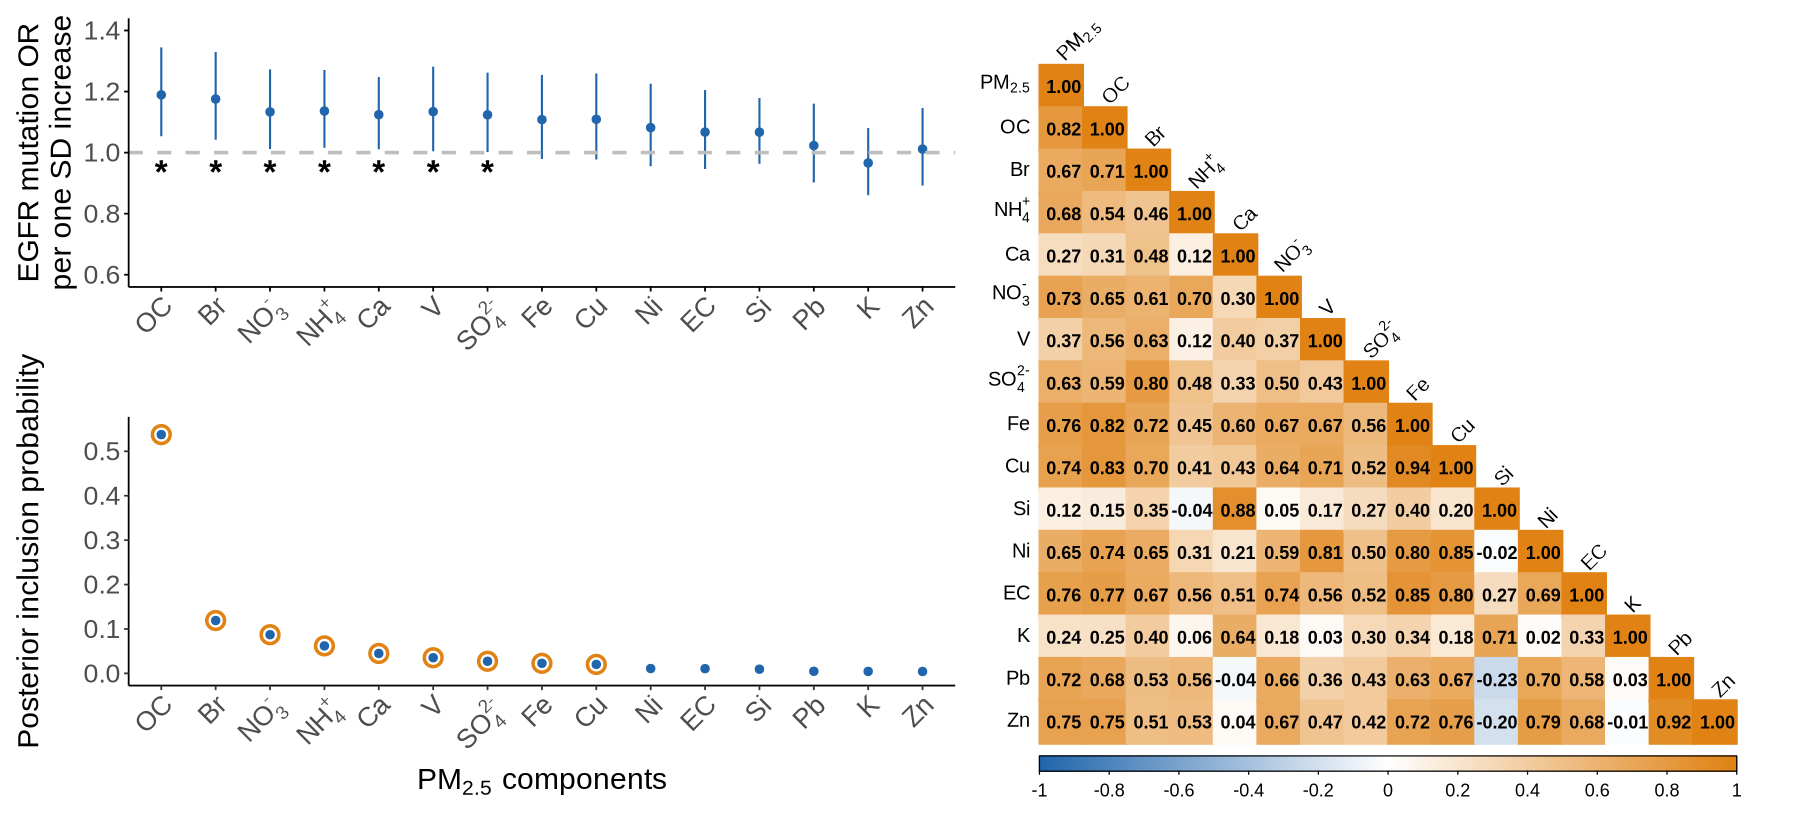

In [16]:
library(cowplot)
library(grid)
library(gridGraphics)
library(patchwork)
set_fig_size(w=15,h=7)

# Create a named vector for chemical labels
param_labels <- c(
  br = expression(Br),
  ca = expression(Ca),
  cu = expression(Cu),
  ec = expression(EC),
  fe = expression(Fe),
  k = expression(K),
  nh4 = expression(NH[4]^"+"),
  ni = expression(Ni),
  no3 = expression(NO[3]^"-"),
  oc = expression(OC),
  pb = expression(Pb),
  si = expression(Si),
  so4 = expression(SO[4]^"2-"),
  v = expression(V),
  z = expression(Zn)
)

p3_labels <- c(
  PM25 = "$PM[2.5]", 
  br = "Br",
  ca = "Ca",
  cu = "Cu",
  ec = "EC",
  fe = "Fe",
  k = "K",
  nh4 = "$NH[4]^'+'",
  ni = "Ni",
  no3 = "$NO[3]^'-'",
  oc = "OC",
  pb = "Pb",
  si = "Si",
  so4 = "$SO[4]^'2-'",
  v = "V",
  z = "Zn"
)[comp_order]

colnames(cor_matrix) <- rownames(cor_matrix) <- p3_labels 
# Update your corrplot code
p3_grob <- grid::grid.grabExpr({
    gridGraphics::grid.echo(function() {
        par(mar = c(0, 0, 0, 0))
        corrplot(cor_matrix,
                 method = "color",
                 col = colorRampPalette(c("#2166AC", "white", "#E08214"))(200),
                 type = "lower",
                 order = "original",
                 tl.col = "black",
                 tl.srt = 45,
                 addCoef.col = "black",
                 tl.cex = 1,
                 cl.cex = 0.9,
                 cl.ratio = 0.1, 
                 number.cex = 0.9)  # Add this line
    })
})

# Wrap p3_grob inside a ggdraw
p3_plot <- cowplot::ggdraw() + draw_grob(p3_grob)

p1 <- p1 + scale_x_discrete(labels = param_labels)
p2 <- p2 + scale_x_discrete(labels = param_labels)

# Stack p1 and p2 vertically (left side)
left_col <- p1 / p2 + plot_spacer() + 
  plot_layout(
    ncol = 1, 
    heights = c(1, 1, 0) # p1 height, p2 height, spacer height
  )

# Assemble full layout: left (p1+p2), right (p3)
final_plot <- left_col | p3_plot

# Display
final_plot

In [17]:
if (is.na(SUBSET_CONDITION$SMOKE3)) {
    group <- 'all'
} else if (SUBSET_CONDITION$SMOKE3) {
    group <- 'smoker'
} else {
    group <- 'non_smoker'
}
ggsave(file = glue('result/finemap_{group}.pdf'), plot = final_plot, w = 15, h = 7)